# Простая рекуррентная сеть на Tensorflow
В данном примере показана работа с рекуррентной нейронной сетью типа LSTM в Tensorflow.
Для примера выбрана **регрессионная задача** расчёта суммы последовательности чисел.

Для каждого $i$-го примера модель предсказывает сумму всех элементов на входе:

$$ y_i = \sum X_i, $$

В одном примере на вход приходит 3 числа:
$$ X_i = [x_1, x_2, x_3] $$

Числа на входе лежат в интервале от 0 до 0.3, для нормализации выхода сети.
$$ x_n \in [0, 0.3], \  0 < \sum X_i < 1 $$

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Данные
Для примера сгенирирует 25 последовательностей случайных чисел длиной 3, 10 последовательностей для обучения и 15 для тестирования.

In [2]:
x_train = np.random.random((10, 3, 1))/3.
x_test  = np.random.random((15, 3, 1))/3.
y_train = np.sum(x_train, axis=1)
y_test  = np.sum(x_test,  axis=1)

## Модель
Для примера рассматриваеться модель на основе LSTM ячейки, можно выбрать любую другую из документации к Tensorflow.

Нам необходимо построить граф преобразований входа $X$ в выход $Y$, для удобства построим граф внутри функции. Данный граф пока ничего не вычисляет, он только указывает последовательность действий.

Рекуррентный слой в Tensorflow принимает данные в виде последоавтельности:
(количество примеров в батче, размерность каждого примера)

В качестве функции ошибки используем среднеквадратичную ошибку (MSE)
$$ mse = \frac {1} {n} \sum (\hat Y - Y)^2$$

### Описываем граф нашей модели
- batch_size -- количество примеров в одной "порции" для обучения или предсказания
- time_steps -- количество элементов в последовательности для одного примера
- input_size -- размерность эелемента в последовательности

In [3]:
def model(X, time_steps, input_size, lstm_size, lstm_out_dim):
    # Сначала меняем местами batch_size и time_steps в X
    # Было  (batch_size, time_steps, input_size),
    # стало (time_steps, batch_size, input_size)
    X = tf.transpose(X, [1, 0, 2])
    
    # Переводим размерность X в двумерный вид
    # Было  (time_steps, batch_size, input_size),
    # стало (time_steps*batch_size, input_size)
    X = tf.reshape(X, [-1, input_size])
    
    # Разбиваем X на time_steps элементов,
    # X стал списоком примеров,
    # где каждый пример представлен элементом с размерностью (batch_size, input_size)
    X = tf.split(0, time_steps, X)
    
    # Объявлем ячейки для рекуррентного слоя
    # lstm_size -- количество ячеек (нейронов)
    # state_is_tuple=True -- говорит, что выход сети и "состояние" сети представлены кортежем
    # Специфика LSTM: forget_bias=1.0 (bias для gate на очистку)
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(lstm_size,
                                             forget_bias=1.0,
                                             state_is_tuple=True)
    
    # Создаём рекуррентный слой из объявленных ранее ячеек
    # lstm_out -- выход сети
    # lstm_states -- список состояний сети
    lstm_out, lstm_states = tf.nn.rnn(lstm_cell, X, dtype=tf.float32)
    
    # Веса для связей
    # W -- веса связей сети
    # B -- для смещения
    W = tf.get_variable("lstm_input_weights", [lstm_size, lstm_out_dim], initializer=tf.random_normal_initializer())
    B = tf.get_variable("lstm_biases", [lstm_out_dim], initializer=tf.random_normal_initializer())
    
    # Применяем веса сети к выходу рекуррентого слоя,
    # линейная функция активации (т.е. как есть так и возвращаем)
    # lstm_out[-1] -- на каждый элемент последовательности
    #     рукуррентый слой возвращаетс активность,
    #     нам важна тольк последняя активность, отражающая всю последовательность
    res = tf.matmul(lstm_out[-1], W) + B
    return res

### Устанавливаем параметры модели и описываем интерфейс взаимодействия с ней

In [4]:
# сбросить в исходное состояние граф, если до этого прводились какие-то оперции с tensorflow
tf.reset_default_graph()

time_steps  = x_train.shape[1] # количество элементов в одной последовательности
input_size  = x_train.shape[2] # размерность элемента последовательности, в нашем случае 1
network_out = y_train.shape[1] # размерность выхода сети
lstm_size = 10                 # количество нейронов в рекуррентном слое


# Определяем в каком виде нам приходят данные,
# placeholder -- определяет только как вид переменной,
# сами данные передаютсья во время обучения или предсказания
X = tf.placeholder("float", [None, time_steps, input_size])
Y = tf.placeholder("float", [None, network_out])

# Создаём экземпляр нашей модели с заданными параметрами
lstm_model = model(X, time_steps, input_size, lstm_size, network_out)

# Определяем функцию ошибки, в данном случае это MSE
cost = tf.reduce_mean(tf.pow(lstm_model - Y, 2))
# Создаём решатель, по алгоритму RMSPropOptimizer, learning_rate = 0.001,
# .minimize(cost) -- означает, что надо максимально минимизировать функцию ошибки
train_op   = tf.train.RMSPropOptimizer(0.001).minimize(cost)

## Обучение и оценка модели

In [5]:
# Списки для хранения результатов обучения
l_pred_train_mse = [] # для тренировочного множества
l_pred_test_mse = []  # для тестировочного множества

# Количество эпох для обучения
n_epoches = 300

# Создаём сессию Tensorflow в которой будем работать
# with tf.device("/gpu:0"):
sess = tf.Session()
with sess.as_default():
    # Инициализируем все переменные в графе
    tf.initialize_all_variables().run()

    for i in range(n_epoches):
        # Одна итерация обучения
        sess.run(train_op, feed_dict={X: x_train, Y: y_train})

        # Предсказание
        pred_train = sess.run(lstm_model, feed_dict={X: x_train})
        pred_test  = sess.run(lstm_model, feed_dict={X: x_test})
        l_pred_train_mse.append(np.mean(np.power(pred_train - y_train, 2)))
        l_pred_test_mse.append(np.mean(np.power(pred_test - y_test, 2)))
                               

### Кривая обучения

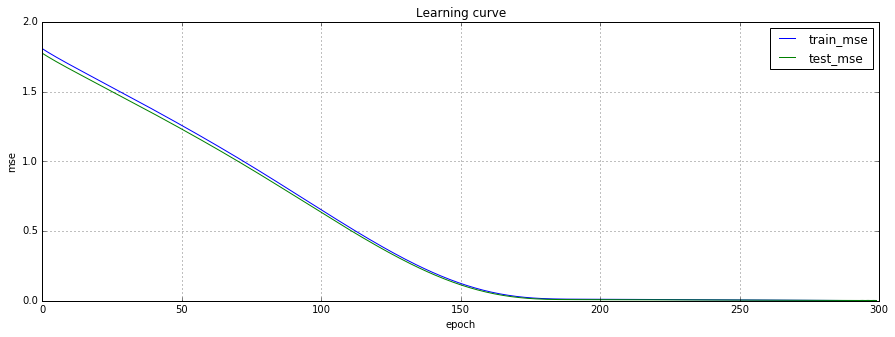

In [6]:
plt.figure(figsize=(15, 5)) # Устанавливаем размер изображения
# рисуем кривую для ошибки на тренировочном множестве
plt.plot(range(n_epoches), l_pred_train_mse, label="train_mse")
# рисуем кривую для ошибки на тестировочном множестве
plt.plot(range(n_epoches), l_pred_test_mse, label="test_mse")
# Задаём название графика
plt.title("Learning curve")
# Подписи к оси X и Y
plt.xlabel("epoch")
plt.ylabel("mse")
# Добавляем легенду на график и сетку
plt.legend()
plt.grid()

## Тестриование модели

In [7]:
# Пропускаем первые n элементов из тестировочного множества
start_offset = 3

# Получаем результат расчёта для новых данных
with sess.as_default():
    pred_test  = sess.run(lstm_model, feed_dict={X: x_test[start_offset:]})

# Выводим
# pred -- предсказанное,
# y -- что должно быть,
# x -- входная последовательность, через "+", мы пытаемся нучить сетку сложению   
for pred, x, y in zip(pred_test, x_test[start_offset:], y_test[start_offset:]):
    print("perd={0:.3f}, y={1:.3f}, x: {2}".format(pred[0], y[0], " + ".join(["{0:.3f}".format(val[0]) for val in x])))

perd=0.623, y=0.612, x: 0.322 + 0.103 + 0.187
perd=0.535, y=0.539, x: 0.150 + 0.193 + 0.197
perd=0.487, y=0.428, x: 0.312 + 0.011 + 0.105
perd=0.496, y=0.517, x: 0.029 + 0.301 + 0.186
perd=0.631, y=0.694, x: 0.123 + 0.256 + 0.316
perd=0.625, y=0.674, x: 0.129 + 0.282 + 0.263
perd=0.333, y=0.243, x: 0.195 + 0.032 + 0.016
perd=0.302, y=0.239, x: 0.119 + 0.004 + 0.117
perd=0.559, y=0.563, x: 0.204 + 0.135 + 0.225
perd=0.530, y=0.507, x: 0.145 + 0.325 + 0.037
perd=0.352, y=0.299, x: 0.138 + 0.032 + 0.130
perd=0.398, y=0.414, x: 0.007 + 0.126 + 0.281


In [8]:
print("Выполнено")

Выполнено
